In [72]:
!pwd

/home/lavanyanemani96


In [73]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

In [74]:
catsd = '/home/stephenportillo/gen_model_hack/greycats_32/'
N = 15747

In [75]:
def load_image(d):
    
    img = Image.open(d)
    img.load()
    data = np.asarray(img, dtype='int32')
    
    return data

In [76]:
catsdata = np.zeros((N, 32, 32))

In [77]:
for i in range(N):
    d = catsd + str(i+1) + '.jpg'
    catsdata[i] = load_image(d)

In [78]:
catsdata.max()

255.0

In [79]:
catsdata = catsdata / 255.

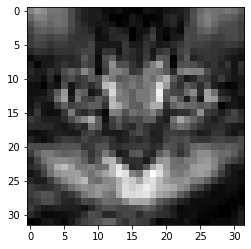

In [80]:
plt.imshow(catsdata[5], cmap='gray')

In [81]:
mydata = catsdata

In [82]:
from sklearn.model_selection import train_test_split

In [314]:
X_train, X_test = train_test_split(mydata, train_size=0.7, shuffle=True, random_state=42)

In [315]:
X_train.max(), X_test.max()

(1.0, 1.0)

In [316]:
# rescaling images
# a, b = 0.0, 1.0 
# X_train = (X_train - a) / (b-a)
# X_test = (X_test - a) / (b-a)

In [317]:
np.shape(X_train), np.shape(X_test)

((11022, 32, 32), (4725, 32, 32))

In [318]:
X_train = X_train.reshape((11022, 32, 32, 1))

In [319]:
X_test = X_test.reshape((4725, 32, 32, 1))

In [320]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, Dropout, BatchNormalization, MaxPool2D
from tensorflow.keras.optimizers import SGD

In [321]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import tensorflow as tf
import datetime, os
from datetime import datetime

In [322]:
!pwd

/home/lavanyanemani96


In [323]:
log_directory = 'logs/fit'

# OPTIONAL: ADD A TIMESTAMP FOR UNIQUE FOLDER
timestamp = datetime.now().strftime("%Y-%m-%d--%H%M")
# log_directory = log_directory + '/' + timestamp

log_directory = log_directory + '/conv_no_af_latentspace_sig_af_training_batch'

board = TensorBoard(log_dir=log_directory,histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1)

In [324]:
# encoder = Sequential()
# encoder.add(Flatten(input_shape=[32,32])) 
# encoder.add(Dense(400,activation="relu"))
# encoder.add(Dense(200,activation="relu"))
# encoder.add(Dense(100,activation="relu"))
# encoder.add(Dense(50,activation="relu"))
# encoder.add(Dense(25,activation="linear"))

encoder = Sequential()

encoder.add(Conv2D(filters=2, kernel_size=3, strides=(1,1), activation='relu', input_shape=(32, 32, 1), padding='same'))
encoder.add(MaxPool2D(pool_size=(2, 2)))

encoder.add(Conv2D(filters=4, kernel_size=3, strides=(1,1), activation='relu', padding='same'))
encoder.add(MaxPool2D(pool_size=(2, 2)))

encoder.add(Conv2D(filters=6, kernel_size=3, strides=(1,1), activation='relu', padding='same'))
encoder.add(MaxPool2D(pool_size=(2, 2)))

encoder.add(Flatten())
encoder.add(Dense(32, input_shape=[96]))

In [325]:
encoder.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 32, 32, 2)         20        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 2)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 16, 16, 4)         76        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 4)           0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 8, 8, 6)           222       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 6)           0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 96)              

In [326]:
32/(32*32)

0.03125

In [327]:
decoder = Sequential()
decoder.add(Dense(96,input_shape=[32],activation='relu'))
decoder.add(Reshape(target_shape=(4, 4, 6),input_shape=[96]))

decoder.add(Conv2DTranspose(filters=4, kernel_size=3, strides=(2,2), padding='same',
                activation='relu'))
decoder.add(Conv2DTranspose(filters=2, kernel_size=3, strides=(2,2), padding='same',
                activation='relu'))
decoder.add(Conv2DTranspose(filters=1, kernel_size=3, strides=(2,2), padding='same',
                activation='sigmoid'))

In [328]:
decoder.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 96)                3168      
_________________________________________________________________
reshape_9 (Reshape)          (None, 4, 4, 6)           0         
_________________________________________________________________
conv2d_transpose_23 (Conv2DT (None, 8, 8, 4)           220       
_________________________________________________________________
conv2d_transpose_24 (Conv2DT (None, 16, 16, 2)         74        
_________________________________________________________________
conv2d_transpose_25 (Conv2DT (None, 32, 32, 1)         19        
Total params: 3,481
Trainable params: 3,481
Non-trainable params: 0
_________________________________________________________________


In [329]:
autoencoder = Sequential([encoder, decoder])

In [330]:
autoencoder.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_32 (Sequential)   (None, 32)                3422      
_________________________________________________________________
sequential_33 (Sequential)   (None, 32, 32, 1)         3481      
Total params: 6,903
Trainable params: 6,903
Non-trainable params: 0
_________________________________________________________________


In [331]:
autoencoder.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [332]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [333]:
from keras.callbacks import ModelCheckpoint

output_directory = 'model_weights'
model_checkpoint = ModelCheckpoint(os.path.join(output_directory , 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'))

In [334]:
autoencoder.fit(X_train, X_train, epochs=10000, validation_data=[X_test, X_test], callbacks=[early_stop], batch_size=128)

Train on 11022 samples, validate on 4725 samples
Epoch 1/10000
11022/11022 [==============================] - 7s 613us/sample - loss: 0.0609 - acc: 0.0047 - val_loss: 0.0544 - val_acc: 0.0060
Epoch 2/10000
11022/11022 [==============================] - 4s 320us/sample - loss: 0.0376 - acc: 0.0066 - val_loss: 0.0283 - val_acc: 0.0075
Epoch 3/10000
11022/11022 [==============================] - 4s 318us/sample - loss: 0.0252 - acc: 0.0075 - val_loss: 0.0230 - val_acc: 0.0078
Epoch 4/10000
11022/11022 [==============================] - 3s 307us/sample - loss: 0.0216 - acc: 0.0076 - val_loss: 0.0204 - val_acc: 0.0079
Epoch 5/10000
11022/11022 [==============================] - 4s 319us/sample - loss: 0.0198 - acc: 0.0077 - val_loss: 0.0192 - val_acc: 0.0079
Epoch 6/10000
11022/11022 [==============================] - 4s 319us/sample - loss: 0.0187 - acc: 0.0077 - val_loss: 0.0183 - val_acc: 0.0079
Epoch 7/10000
11022/11022 [==============================] - 3s 309us/sample - loss: 0.0179 -

In [335]:
# from tensorflow.keras.models import load_model

# for i in range(13):
    
#     n = i+1
#     if n < 10:
#         name = 'model_weights/weights.0'+str(i+1)+'-0.00.hdf5'
#     else:
#         name = 'model_weights/weights.'+str(i+1)+'-0.00.hdf5'

#     model = load_model(name)
    
#     image_i = model.predict(X_test)
#     epochimg = image_i[0].reshape((32, 32))
    
#     plt.savefig('model_weights/'+str(i+1)+'.jpg')

In [336]:
# print(log_directory)

In [337]:
losses = pd.DataFrame(autoencoder.history.history)

In [338]:
losses.columns

Index(['loss', 'acc', 'val_loss', 'val_acc'], dtype='object')

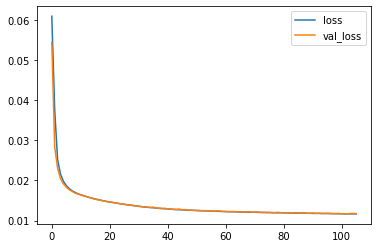

In [339]:
losses[['loss','val_loss']].plot()

In [343]:
passed_images = autoencoder.predict(X_test)

In [344]:
np.shape(passed_images)

(4725, 32, 32, 1)

In [345]:
passed_images = passed_images.reshape((4725, 32, 32))

In [346]:
X_test_r = X_test.reshape((4725, 32, 32))

In [347]:
def plot_cat_wall(fake_imgs, title, cmap='Greys'):
    
    fig, axis = plt.subplots(nrows=4, ncols=4, figsize=(4, 5.2))
    
    for i, ax in enumerate(axis.ravel()):
        ax.imshow(fake_imgs[i, :, :], interpolation='bilinear',
                  cmap=cmap, origin='upper', 
                  aspect='equal')
    for ax in axis.ravel():
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    fig.subplots_adjust(wspace=0, hspace=0, left=0, right=1)
    fig.suptitle(title)
    plt.show()

In [348]:
n = 4207

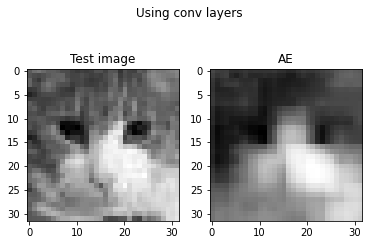

In [349]:
f = plt.figure()
f.add_subplot(1,2, 2)
plt.imshow(passed_images[n], cmap='gray')
plt.title('AE')

f.add_subplot(1,2, 1)
plt.imshow(X_test_r[n], cmap='gray')
plt.title('Test image')

plt.suptitle('Using conv layers')
plt.show(block=True)

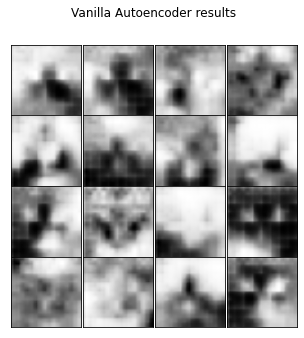

In [351]:
plot_cat_wall(passed_images[n:n+16], 'Vanilla Autoencoder results')

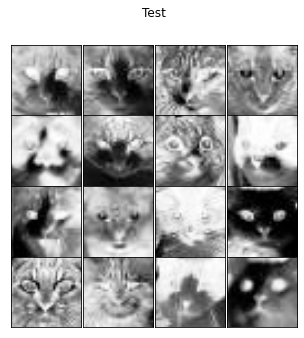

In [352]:
plot_cat_wall(X_test_r[n:n+16], 'Test')